# Analysis of my beer tastes

During my time in graduate school, I had a Friday afternoon beer group with a few friends. We would try all manner of interesting beers, but never quite remembered what I liked. Eventually I started keeping track of what I had, along with giving a rating from 1-10. Eventually I started doing much more analysis, and used this as an occasion to learn SQL and Pandas. This is a cleaned-up version of the analysis I've done.

My persona rating system is as follows: 5 and below I consider not worth finishing, 6 is something that's fine, and 7 and above are what's worth having again.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime as dt
import geopandas
%matplotlib inline

sns.set_style("white")

pd.set_option('display.max_rows', 200)

In [2]:
beers = pd.read_csv('./Beers2.csv', sep=';')
brands = pd.read_csv('./Brands.csv', sep=';')
taxonomy = pd.read_csv('./Beer_taxonomy.csv', sep=';')
regions = pd.read_csv('./Regions.csv', sep=';')

In [3]:
beerskeep = [u'BeerName', u'Brewery', u'Type', u'Origin',
             u'ABV', u'HowIDrank', u'Rating', u'Rose Rating']
beers = beers[beerskeep]

In [4]:
# Ensuring that all regions and taxonomies are covered
missing_regions = set(beers['Origin']) - set(regions['Region'])
if missing_regions:
    raise UserWarning("Missing the following regions: %s" % list(missing_regions))
mission_taxo = set(beers['Type']) - set(taxonomy['Type'])
if missing_regions:
    raise UserWarning("Missing the following taxonomies: %s" % list(missing_taxo))

In [5]:
df = pd.merge(beers, brands, on='Brewery', how='left')
# Left because NaN is "craft" beer
df = pd.merge(df, taxonomy, on='Type', how='inner')
df = pd.merge(df, regions, left_on='Origin', right_on='Region')

In [6]:
df.head()

,BeerName,Brewery,Type,Origin,ABV,HowIDrank,Rating,Rose Rating,Corporation,BeerClass,AleOrLager,Region,Country,Superregion,Continent
0,Delirium Tremens,Huyghe Brewery,Strong Pale Ale,Belgium,8.5,Bottle at desk,6,NaN,NaN,Pale,Ale,Belgium,Belgium,EU-Western,Europe
1,Bush Ambree,Brasserie Dubuisson,Strong Pale Ale,Belgium,12.0,Bottle at desk,8,NaN,NaN,Pale,Ale,Belgium,Belgium,EU-Western,Europe
2,Duvel,Duvel Moortgat Brewery,Strong Pale Ale,Belgium,8.5,Bottle at desk,7,NaN,Moortgat,Pale,Ale,Belgium,Belgium,EU-Western,Europe
3,Hoegaarden Grand Cru,Hoegaarden Brewery,Strong Pale Ale,Belgium,8.7,Bottle at desk,8,NaN,AB / InBev,Pale,Ale,Belgium,Belgium,EU-Western,Europe
4,Delirium Christmas/Noel,Huyghe Brewery,Strong Pale Ale,Belgium,10.0,Bottle at desk,7,NaN,NaN,Pale,Ale,Belgium,Belgium,EU-Western,Europe


## Listing the top beers

Just some of the best ones.

In [7]:
topoverall = df[['BeerName', 'Brewery', 'Country', 'Type', 'Rating']][df['Rating'] >= 9]
topoverall = topoverall.sort_values(
    by=['Rating', 'Country', 'Brewery'],
    ascending=[False, True, True])
topoverall

,BeerName,Brewery,Country,Type,Rating
23,Cuvee des Jacobins Rouge,Bockor Brewery,Belgium,Flanders Red Ale,10
22,Duchesse de Bourgogne,Verhaeghe Vichte,Belgium,Flanders Red Ale,10
193,Red Poppy Ale,Lost Abbey,US,Sour Red,10
12,Oude Geuze Boon,Boon Brewery,Belgium,Gueze,9
38,Liefmans Cuvee-Brut,Liefmans,Belgium,Fruit Beer,9
700,Man Overboard,Side Launch,Canada,Imperial Stout,9
532,La Fin du Monde,Unibroue,Canada,Tripel,9
437,Harviestoun Ola Dubh (12 Year),Harviestoun Brewery,UK,Old Ale,9
415,Yorkshire Stingo,Samuel Smith,UK,Strong Ale,9
420,St. Peter's Cream Stout,St. Peter's Brewery,UK,Stout,9


A lot of sours, mostly. I'm glad they've become the [new craft-brewing fad](https://www.npr.org/sections/thesalt/2013/10/15/234914933/pucker-up-america-beers-are-going-sour). And that [Alamanac](https://www.almanacbeer.com/) opened a taproom close to me in Alameda.

## Beer taxonomy: Ale versus Lager versus Cider

The biggest distinguishing factor between beers is whether they are an ale or a lager (and I have a few ciders and other similar types as well). So let's see how things break down there.

In [8]:
taxomean = df.groupby('AleOrLager')['Rating'].mean()
taxomean.name = 'Mean'
taxostd = df.groupby('AleOrLager')['Rating'].std()
taxostd.name = 'StDev'
taxocount = df.groupby('AleOrLager')['Rating'].size()
taxocount.name = 'Count'

In [9]:
ALCstats = pd.DataFrame(data=[taxomean, taxostd, taxocount]).transpose()
ALCstats.index.names = ['Beer Style']
ALCstats['Mean'] = ALCstats['Mean'].map('{:,.2f}'.format)
ALCstats['StDev'] = ALCstats['StDev'].map('{:,.2f}'.format)
ALCstats['Count'] = ALCstats['Count'].map('{:,.0f}'.format)
ALCstats.sort_values(by='Mean', inplace=True, ascending=False)
ALCstats

,Mean,StDev,Count
Beer Style,,,
Kvass,7.00,nan,1
Ale,5.95,1.54,421
Cider,5.84,1.36,63
Other,5.77,1.41,22
Mead,5.50,0.71,2
Lager,5.00,1.38,237


In [10]:
# Two sided p-value
Ale_ratings = df[df['AleOrLager'] == 'Ale']['Rating']
Lager_ratings = df[df['AleOrLager'] == 'Lager']['Rating']

AL_t, AL_p = stats.ttest_ind(Ale_ratings, Lager_ratings, equal_var=False)
print('Two-sided t-test p-value Ale vs Lager: {:.3e}'.format(AL_p))

Two-sided t-test p-value Ale vs Lager: 2.622e-15


Text(0.5,1,u'Beer rating by type')

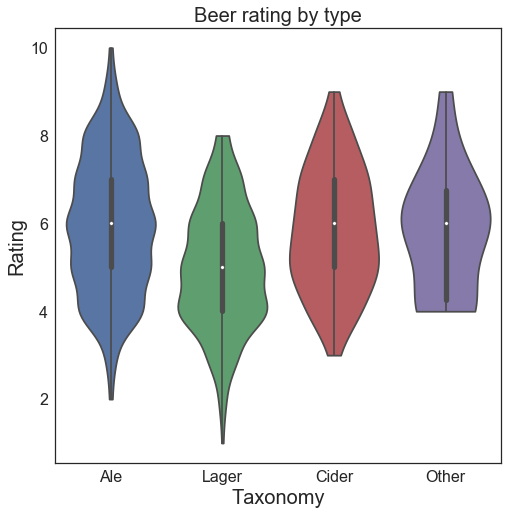

In [11]:
fig, ax = plt.subplots(figsize=(8,8))

sns.violinplot(x='AleOrLager', y='Rating',
               data=df[~df['AleOrLager'].isin(['Kvass', 'Mead'])],
               ax=ax, scale='width', cut=0,
               order=['Ale', 'Lager', 'Cider', 'Other'])
ax.tick_params(labelsize=16)
ax.set_xlabel("Taxonomy", fontsize=20)
ax.set_ylabel("Rating", fontsize=20)
ax.set_title("Beer rating by type", fontsize=20)

Looks like lagers are a clear loser, while everything else works out to be roughly similar (I only have one kvass and two mead drinks, so I'm ignoring).

We can also see that drink ratings (especially for ales) has a somewhat "normal" distribution. I feel like this indicates that my ratings are fairly well calibrated.

And just because I love sours, let's see how they rate relative to the rest of ales.

Number of sours 48
Average rating for sours 6.94


Text(0.5,1,u'Sours versus ales')

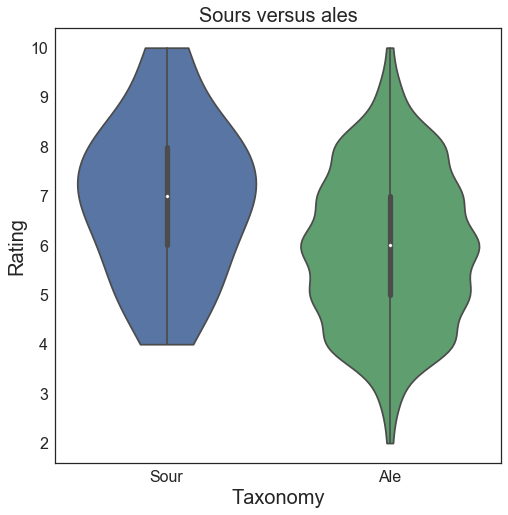

In [12]:
df_sour = df[df['BeerClass'] == 'Sour'][['Rating']]
print "Number of sours %d" % len(df_sour['Rating'])
print "Average rating for sours %.2f" % df_sour['Rating'].mean()
df_ale = df[df['AleOrLager'] == 'Ale'][['Rating']]
df_sour['Class'] = 'Sour'
df_ale['Class'] = 'Ale'
df_sacomp = pd.concat([df_sour, df_ale])

fig, ax = plt.subplots(figsize=(8,8))

sns.violinplot(x='Class', y='Rating',
               data=df_sacomp,
               ax=ax, scale='width', cut=0)
ax.tick_params(labelsize=16)
ax.set_xlabel("Taxonomy", fontsize=20)
ax.set_ylabel("Rating", fontsize=20)
ax.set_title("Sours versus ales", fontsize=20)

So I found sours on average a full rating even better!

## How do different countries rank?

When I lived in Zurich, I often went to [Drinks of the World](https://www.beerworld.ch/) to sample all sorts of different drinks. On coming home, I've made a priority to see else I can find around the world.

In [13]:
# Several countries I only have one or two drinks from, so let's only
# keep the ones where I have 3 or more.
country_thresh = 3

In [14]:
countrymean = df.groupby('Country')['Rating'].mean() 
countrymean.name = 'Mean'
countrystd = df.groupby('Country')['Rating'].std()
countrystd.name = 'StDev'
countrycount = df.groupby('Country')['Rating'].size()
countrycount.name = 'Count'

In [15]:
countrystats = pd.DataFrame(data=[countrymean, countrystd, countrycount]).transpose()
countrystats = countrystats[countrystats['Count'] >= country_thresh]
countrystats.sort_values(by=['Mean', 'Count'], ascending=[False, True], inplace=True)
countrystats['Mean'] = countrystats['Mean'].round(decimals=2)
countrystats['StDev'] = countrystats['StDev'].round(decimals=2)
countrystats['Count'] = countrystats['Count'].round(decimals=0)
countrystats

,Mean,StDev,Count
Country,,,
Belgium,6.74,1.37,46.0
Lithuania,6.50,1.22,6.0
US,6.03,1.41,310.0
Brazil,6.00,1.00,3.0
UK,5.98,1.64,49.0
Italy,5.75,1.18,16.0
Spain,5.71,1.60,7.0
Japan,5.69,1.11,13.0
Mexico,5.56,1.67,9.0


Ales, lagers, and ciders, independently.

In [16]:
Acountry_thresh = 3
Lcountry_thresh = 3
Ccountry_thresh = 3

Acountrymean = df[df['AleOrLager']=='Ale'].groupby('Country')['Rating'].mean() 
Acountrymean.name = 'Ale Mean'
Acountrystd = df[df['AleOrLager']=='Ale'].groupby('Country')['Rating'].std()
Acountrystd.name = 'Ale StDev'
Acountrycount = df[df['AleOrLager']=='Ale'].groupby('Country')['Rating'].size()
Acountrycount.name = 'Ale Count'

Lcountrymean = df[df['AleOrLager']=='Lager'].groupby('Country')['Rating'].mean() 
Lcountrymean.name = 'Lager Mean'
Lcountrystd = df[df['AleOrLager']=='Lager'].groupby('Country')['Rating'].std()
Lcountrystd.name = 'Lager StDev'
Lcountrycount = df[df['AleOrLager']=='Lager'].groupby('Country')['Rating'].size()
Lcountrycount.name = 'Lager Count'

Ccountrymean = df[df['AleOrLager']=='Cider'].groupby('Country')['Rating'].mean() 
Ccountrymean.name = 'Cider Mean'
Ccountrystd = df[df['AleOrLager']=='Cider'].groupby('Country')['Rating'].std()
Ccountrystd.name = 'Cider StDev'
Ccountrycount = df[df['AleOrLager']=='Cider'].groupby('Country')['Rating'].size()
Ccountrycount.name = 'Cider Count'

In [17]:
Acountrystats = pd.DataFrame(data=[Acountrymean, Acountrystd, Acountrycount]).transpose()
Acountrystats = Acountrystats[Acountrystats['Ale Count'] >= Acountry_thresh]
Acountrystats.sort_values(by='Ale Mean', ascending=False, inplace=True)
Acountrystats['Ale Mean'] = Acountrystats['Ale Mean'].round(decimals=2)
Acountrystats['Ale StDev'] = Acountrystats['Ale StDev'].round(decimals=2)
Acountrystats['Ale Count'] = Acountrystats['Ale Count'].round(decimals=0)

Acountrystats

,Ale Mean,Ale StDev,Ale Count
Country,,,
Belgium,6.75,1.30,44.0
UK,6.28,1.77,36.0
Italy,6.20,1.30,5.0
US,6.09,1.43,220.0
Australia,6.00,1.00,3.0
Canada,5.79,1.97,14.0
Japan,5.75,1.28,8.0
Germany,5.45,1.44,11.0
Poland,5.33,1.21,6.0


In [18]:
Lcountrystats = pd.DataFrame(data=[Lcountrymean, Lcountrystd, Lcountrycount]).transpose()
Lcountrystats = Lcountrystats[Lcountrystats['Lager Count'] >= Lcountry_thresh]
Lcountrystats.sort_values(by='Lager Mean', ascending=False, inplace=True)
Lcountrystats['Lager Mean'] = Lcountrystats['Lager Mean'].round(decimals=2)
Lcountrystats['Lager StDev'] = Lcountrystats['Lager StDev'].round(decimals=2)
Lcountrystats['Lager Count'] = Lcountrystats['Lager Count'].round(decimals=0)

Lcountrystats

,Lager Mean,Lager StDev,Lager Count
Country,,,
Brazil,6.00,1.00,3.0
Lithuania,6.00,1.15,4.0
US,5.70,1.22,40.0
Russia,5.40,1.17,10.0
Italy,5.38,0.92,8.0
Japan,5.33,1.15,3.0
Germany,5.27,1.67,15.0
India,5.25,0.96,4.0
Austria,5.25,1.89,4.0


In [32]:
Ccountrystats = pd.DataFrame(data=[Ccountrymean, Ccountrystd, Ccountrycount]).transpose()
Ccountrystats = Ccountrystats[Ccountrystats['Cider Count'] >= Ccountry_thresh]
Ccountrystats.sort_values(by='Cider Mean', ascending=False, inplace=True)
Ccountrystats['Cider Mean'] = Ccountrystats['Cider Mean'].round(decimals=2)
Ccountrystats['Cider StDev'] = Ccountrystats['Cider StDev'].round(decimals=2)
Ccountrystats['Cider Count'] = Ccountrystats['Cider Count'].round(decimals=0)

Ccountrystats

,Cider Mean,Cider StDev,Cider Count
Country,,,
US,6.10,1.50,40.0
France,6.00,1.00,3.0
UK,5.44,0.73,9.0
Switzerland,4.33,0.58,3.0


Thoughts about these country ratings:
- Generally, I'm finding the US, Belgium, and UK to be the best all around. And for cider, the US is a stand-out, which [is right and proper](https://www.cntraveler.com/story/why-hard-cider-is-the-ultimate-american-drink).
- Italy is surprisingly good! Looks like Italy's [new craft beer scene](https://www.winemag.com/2018/03/16/italy-craft-beer/) is making good strides.
- Germany and the Czech Republic are major disappointments. When I've pointed this out, all my friends who have lived in Germany have gotten super-defensive, but German beer has largely become an [industrial commodity](https://www.europeanbeerguide.net/gersbeer.htm) and the Reinheitsgebot [is a joke](https://www.europeanbeerguide.net/reinheit.htm). Czech beer is suffering from a similar fate. I'm also not sure what's going on with Ireland or the Netherlands.
- Though Poland does poorly, I do want to give them special mention for introducing me to the [Grodziskie](https://draftmag.com/smoke-signals-grodziskie/), which has probably been the most interesting beer I've had. Not necessarily the best, but definitely interesting.

In [21]:
world_map = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world_map = world_map[(world_map.pop_est>0) & (world_map.name!="Antarctica")]
# Since I use terms like US and UK, rename
rename_dict = {'United States': 'US', 'United Kingdom': 'UK', 'Czech Rep.': 'Czech Republic'}
world_map['name'] = world_map['name'].replace(to_replace=rename_dict)

world_ratings = pd.merge(world_map, countrystats[['Mean']], left_on='name', right_index=True, how='outer')

if len(world_ratings[pd.isnull(world_ratings['continent'])]):
    print "Missing values"
    world_ratings[pd.isnull(world_ratings['continent'])]

Text(0.5,1,u'World-wide ratings')

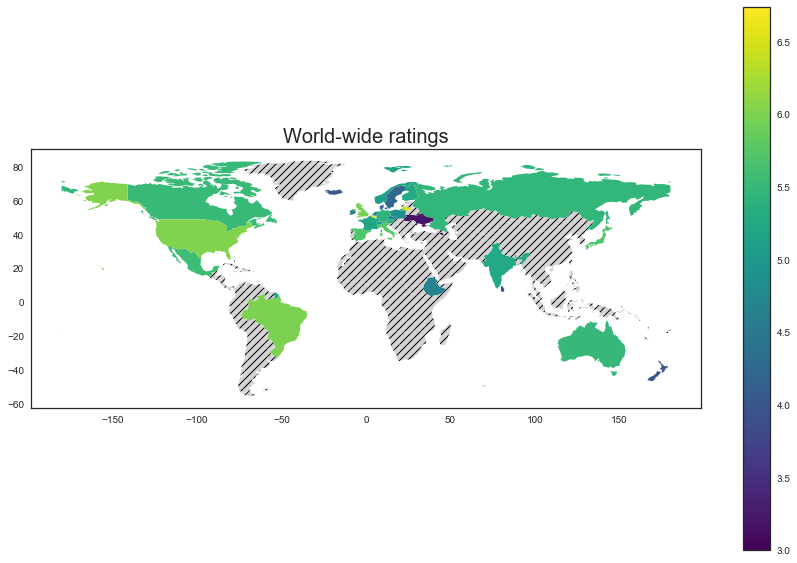

In [25]:
ax = world_ratings[~pd.isnull(world_ratings.Mean)].plot(
    column='Mean', figsize=(15, 10), legend=True, cmap='viridis')
world_ratings[pd.isnull(world_ratings.Mean)].plot(
    color='lightgrey', hatch='///', ax=ax)
ax.set_title("World-wide ratings", fontsize=20)

(30, 85)

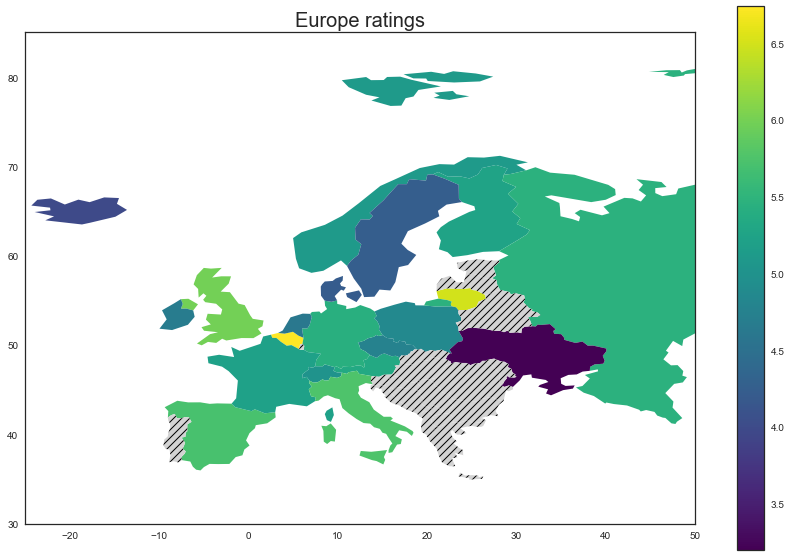

In [31]:
eur_ratings = world_ratings[world_ratings['continent'] == 'Europe']
ax = eur_ratings[~pd.isnull(eur_ratings.Mean)].plot(
    column='Mean', figsize=(15, 10), legend=True, cmap='viridis')
eur_ratings[pd.isnull(eur_ratings.Mean)].plot(
    color='lightgrey', hatch='///', ax=ax)
ax.set_title("Europe ratings", fontsize=20)
ax.set_xlim([-25, 50])
ax.set_ylim([30, 85])

## State-level analysis

Since I've had so many American (and Canadian) drinks, let's break down by state/province.

In [33]:
state_thresh = 3

states_df = df[df['Country'].isin(['US', 'Canada'])]

statemean = states_df.groupby('Origin')['Rating'].mean() 
statemean.name = 'Mean'
statestd = states_df.groupby('Origin')['Rating'].std()
statestd.name = 'StDev'
statecount = states_df.groupby('Origin')['Rating'].size()
statecount.name = 'Count'

statestats = pd.DataFrame(data=[statemean, statestd, statecount]).transpose()
statestats.index.names = ['State']
statestats = statestats[statestats['Count'] >= state_thresh]
statestats.sort_values(by='Mean', ascending=False, inplace=True)
statestats['Mean'] = statestats['Mean'].round(decimals=2)
statestats['StDev'] = statestats['StDev'].round(decimals=2)
statestats['Count'] = statestats['Count'].round(decimals=2)

statestats

,Mean,StDev,Count
State,,,
Alaska,7.20,0.84,5.0
Delaware,6.90,1.37,10.0
Maryland,6.75,1.89,4.0
Illinois,6.60,1.14,5.0
Michigan,6.57,2.23,7.0
Ontario,6.50,1.87,6.0
Washington,6.40,1.52,5.0
Montana,6.33,0.58,3.0
Oklahoma,6.33,1.53,3.0


In [37]:
states = geopandas.read_file('ne_50m_admin_1_states_provinces.shp')
us_ca_states = states[states['iso_a2'].isin(["US", "CA"])]
us_ca_states['name'] = us_ca_states['name'].replace(to_replace={u"Québec": "Quebec"})

us_ca_ratings = pd.merge(us_ca_states, statestats[['Mean']], left_on='name', right_index=True, how='outer')

if len(us_ca_ratings[pd.isnull(us_ca_ratings['iso_3166_2'])]):
    print "Missing values"
    print us_ca_ratings[pd.isnull(us_ca_ratings['iso_3166_2'])]

/Users/panzel/Envs/mm_py2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5,1,u'US and Canada state ratings')

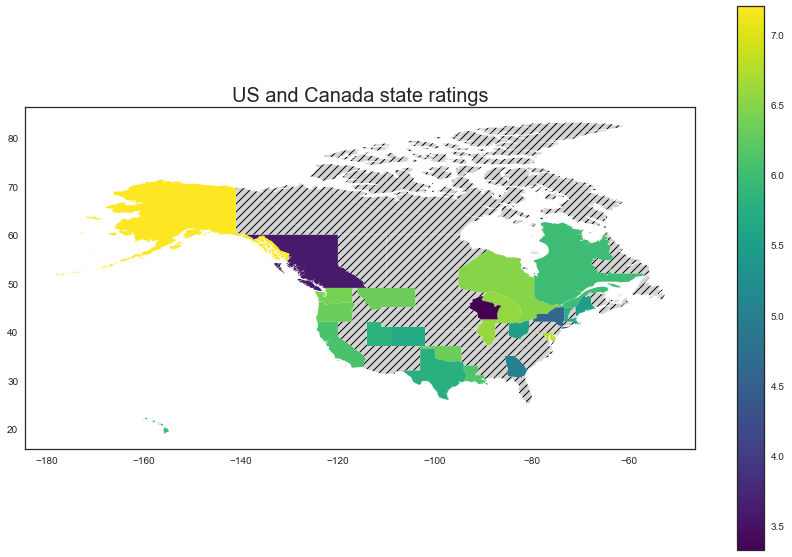

In [39]:
ax = us_ca_ratings[~pd.isnull(us_ca_ratings.Mean)].plot(
    column='Mean', figsize=(15, 10), legend=True, cmap='viridis')
us_ca_ratings[pd.isnull(us_ca_ratings.Mean)].plot(
    color='lightgrey', hatch='///', ax=ax)
ax.set_title("US and Canada state ratings", fontsize=20)

T

## Look at big beer corporations

Most of my peers have some revulsion to "corporate beer", and people can get a [little silly about this](https://consumerist.com/2016/06/20/judge-dismisses-blue-moon-craft-beer-lawsuit-against-millercoors-again/index.html). But the question remains - is craft beer inherently better than corporate beer?

In [ ]:
corp_thresh = 3

corpmean = df.groupby('Corporation')['Rating'].mean() 
corpmean.name = 'Mean'
corpstd = df.groupby('Corporation')['Rating'].std()
corpstd.name = 'StDev'
corpcount = df.groupby('Corporation')['Rating'].size()
corpcount.name = 'Count'

# Beers that don't have a corporation listed are "craft/independent"
craftbeers = df[df['Corporation'].isnull()]
craftmean = craftbeers['Rating'].mean()
craftstd = craftbeers['Rating'].std()
craftcount = len(craftbeers['Rating'])

In [ ]:
corpstats = pd.DataFrame(data=[corpmean, corpstd, corpcount]).transpose()
corpstats = corpstats[corpstats['Count'] >= corp_thresh]

# Get the list of corporations without the Craft/Independent
corplist = corpstats.reset_index(inplace=False)
corplist = corplist['Corporation']

corpstats.loc['Craft / Independent'] = [craftmean, craftstd, craftcount]
corpstats.sort_values(by='Mean', ascending=False, inplace=True)
corpstats['Mean'] = corpstats['Mean'].map('{:,.2f}'.format)
corpstats['StDev'] = corpstats['StDev'].map('{:,.2f}'.format)
corpstats['Count'] = corpstats['Count'].map('{:,.0f}'.format)

In [ ]:
craftratings = craftbeers['Rating']
corp_p_series = pd.Series([], name='Two-sided p')
for corp in corplist:
    corpratings = df[df['Corporation']==corp]['Rating']
    t, corp_p = stats.ttest_ind(craftratings,corpratings, equal_var=False)
    corp_p_series[corp] = corp_p

corpstats['Two-sided p'] = corp_p_series
corpstats['Two-sided p'] = corpstats['Two-sided p'].map('{:,.4f}'.format)
corpstats.replace('nan',' ', regex=True, inplace=True)

corpstats

Anhauser-Busch/InBEV actually does quite reasonably (so much for beer snobbery), and Moortgat and Samuel Smith are doing very well. Carlsberg just edges a bit below (when I had previously run this, it was on par with many of the others). It appears the only corporations I think are stinkers are SABMiller, Heineken, and Molson.

## Does ABV affect my ratings?

How do I feel about boozier beer?

In [ ]:
ABVvals = df[['ABV', 'Rating']].copy()
ABVvals.dropna(subset=['ABV','Rating'], inplace=True)
ABVslope, ABVintercept, ABVr_value, ABVp_value, ABVstd_err = stats.linregress(ABVvals['ABV'], ABVvals['Rating'])
print([ABVslope, ABVintercept, ABVr_value, ABVp_value, ABVstd_err])
print("R^2 value %.3f" % ABVr_value**2)

In [ ]:
size_factor_for_ABVscatter = 50

listcounts = ABVvals.groupby(['ABV', 'Rating']).size()
ABV_list = []
ABV_rats = []
ABV_count = []
for val in listcounts.index.values:
    xABV, yABV = val
    ABV_list.append(xABV)
    ABV_rats.append(yABV)
for countin in listcounts:
    ABV_count.append(countin)
# print(ABV_list)
# print(ABV_rats)
# print(ABV_count)
ABV_list=np.array(ABV_list)
ABV_rats=np.array(ABV_rats)
ABV_count=size_factor_for_ABVscatter*np.array(ABV_count)

ABV_fit_x = np.linspace(0, 14, num=100)
ABV_fit_y = ABVintercept+ABVslope*ABV_fit_x

plt.figure(figsize=(16, 6))
plt.scatter(ABV_list, ABV_rats, s=ABV_count, alpha=0.5, color='g')
plt.plot(ABV_fit_x, ABV_fit_y, 'k--', linewidth=2)
plt.axis([0, 14, 0, 11])
plt.xlabel('ABV', fontsize=16)
plt.ylabel('Rating', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show

From the P-value of 1.1e-6, we do see that there is a dependence on ABV, but this is a rather weak dependence overall.